# Лабораторная работа №3. "Классификация. Нейронные сети"

**Цель работы:** изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard.

**Постановка задачи:**

Необходимо выбрать и подготовить датасет для классификации, затем построить классификационные модели с помощью пяти методов:

1.  **Наивный Байесовский классификатор** (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);
2.  **Деревья решений** (Decision Tree);
3.  **Линейный дискриминантный анализ** (Linear Discriminant Analysis);
4.  **Метод опорных векторов** (Support Vector Machines);
5.  **Метод ближайших соседей** (k-Nearest Neighbors);

Затем сравните качество работы классификаторов с помощью следующих метрик:

*   **Accuracy** (точность),
*   **Precision** (доля правильно классифицированных положительных примеров),
*   **Recall** (чувствительность, доля верно найденных положительных примеров),
*   **F1-Score** (среднее гармоническое precision и recall),
*   **Площадь под кривой ROC** (AUC-ROC).

Настройте гиперпараметры каждого метода и проведите исследование влияния различных параметров на качество классификации.

Реализуйте и протестируйте нейронную сеть на TensorFlow, исследуйте эффект настройки гиперпараметров и визуализируйте процесс обучения с помощью инструмента TensorBoard.

**(Опционально на дополнительные баллы):** Постройте нейронную сеть для классификации на TensorFlow. Организуйте 5-кратную кросс-валидацию для надежной оценки качества. Методом Grid Search с кросс-валидацией подберите оптимальную скорость обучения (3 различных значения) и архитектуру сети (3 варианта). Настройте TensorBoard для отслеживания accuracy / loss на каждом фолде. Сравнения различных конфигураций модели. Сравните финальную accuracy с baseline-моделью и проанализируйте эффект от настройки параметров.

In [11]:
import kagglehub

path = kagglehub.dataset_download("prince2004patel/iti-student-dropout-synthetic-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\vaind\.cache\kagglehub\datasets\prince2004patel\iti-student-dropout-synthetic-dataset\versions\1


<h3>Описание датасета</h3>
Этот набор данных содержит 22 признака, относящиеся к демографическим, академическим, личным и семейным характеристикам студентов ITI, а также целевую переменную dropout (Да/Нет). Он был синтетически сгенерирован для исследований и построения моделей машинного обучения для оценки риска отсева студентов.

Набор данных включает следующие категории признаков:

1. **Демография студента**  
   - возраст (`age`): целое, 15–30  
   - пол (`gender`): категориальный (Мужской / Женский)  
   - тип местности (`location_type`): категориальный (Сельская / Полугородская / Городская)  
   - доход семьи (`family_income`): вещественный, INR 2000–50000  
   - расстояние до института (`distance_to_institute`): вещественный, 0.5–50 км  

2. **Академические факторы**  
   - оценки за 10-й класс (`tenth_marks`): вещественный, 0–100  
   - выбранная программа обучения (`program_enrolled`): категориальный (Mechanical / Electrical / ECE / Civil / Welding / Plumbing / Computer IT)  
   - посещаемость (`attendance_rate`): вещественный, 0–100  
   - средний балл тестов (`test_scores_avg`): вещественный, 0–100  
   - оценка практических навыков (`practical_skills_rating`): вещественный, 0–100  
   - долги по предметам (`backlogs`): целое, 0–9  

3. **Вовлечённость и поддержка**  
   - статус финансовой помощи (`financial_aid_status`): категориальный (Нет / Частично / Полная)  
   - работа неполный день (`part_time_work`): категориальный (Да / Нет)  
   - оценка качества преподавания (`teaching_quality_rating`): целое, 1–10  

4. **Личные факторы**  
   - соответствие карьере (`career_alignment`): категориальный (Низкое / Среднее / Высокое)  
   - мотивация (`motivation_score`): целое, 1–10  
   - поддержка семьи (`family_support`): категориальный (Низкая / Средняя / Высокая)  
   - уровень стресса (`stress_levels`): категориальный (Низкий / Средний / Высокий)  

5. **Техническая и цифровая грамотность**  
   - проблемы с интернет-соединением (`internet_connectivity_issues`): категориальный (Нет проблем / Периодические / Частые)  

6. **Семейные и социальные факторы**  
   - количество братьев и сестёр (`num_siblings`): целое, 1–9  
   - образование родителей (`parents_education`): категориальный (Нет / Оба в колледже / Оба в школе / Смешанное)  
   - опыт травли (`ragging_experience`): категориальный (Да / Нет)  

7. **Целевая переменная**  
   - отчисление (`dropout`): категориальный (Да / Нет)

<h3>Импорт библиотек</h3>

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os

<h3>Описательный анализ</h3>

In [13]:
dataset_path = r"F:\ml\datasets\iti_student_dropout_dataset.csv"
df = pd.read_csv(dataset_path)

print("Первые строки")
print(df.head())
print("\nИнформация о данных")
print(df.info())

Первые строки
   gender location_type program_enrolled financial_aid_status part_time_work  \
0  Female         Urban              ECE              Partial            Yes   
1    Male         Rural       Electrical              Partial            Yes   
2    Male         Urban      Computer IT              Partial            Yes   
3    Male         Rural         Plumbing              Partial            Yes   
4  Female    Semi-urban              ECE              Partial            Yes   

  career_alignment family_support stress_levels internet_connectivity_issues  \
0              Low           High           Low                    No Issues   
1              Low         Medium        Medium            Occasional Issues   
2              Low            Low        Medium              Frequent Issues   
3           Medium            Low          High                    No Issues   
4              Low         Medium        Medium                    No Issues   

  parents_education  ...

In [14]:
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения по столбцам:
gender                          0
location_type                   0
program_enrolled                0
financial_aid_status            0
part_time_work                  0
career_alignment                0
family_support                  0
stress_levels                   0
internet_connectivity_issues    0
parents_education               0
ragging_experience              0
age                             0
family_income                   0
distance_to_institute           0
tenth_marks                     0
attendance_rate                 0
test_scores_avg                 0
practical_skills_rating         0
backlogs                        0
teaching_quality_rating         0
motivation_score                0
num_siblings                    0
dropout                         0
dtype: int64


In [15]:
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

target_col = "dropout"
X = df.drop(columns=[target_col])
y = df[target_col]

### Наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB)


=== GaussianNB ===
Accuracy: 0.8533
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1200
           1       0.87      0.77      0.82       900

    accuracy                           0.85      2100
   macro avg       0.86      0.84      0.85      2100
weighted avg       0.85      0.85      0.85      2100



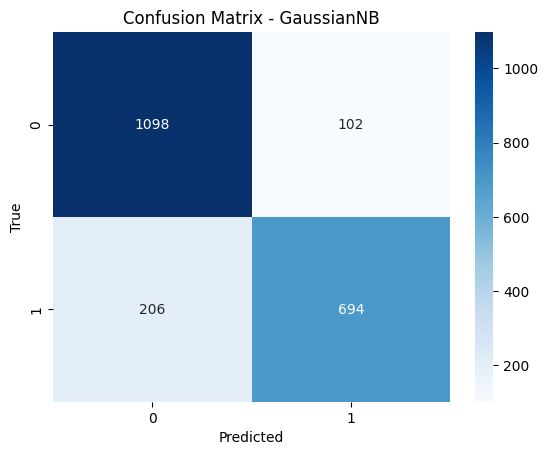


=== MultinomialNB ===
Accuracy: 0.7719
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      1200
           1       0.89      0.53      0.67       900

    accuracy                           0.77      2100
   macro avg       0.81      0.74      0.75      2100
weighted avg       0.80      0.77      0.76      2100



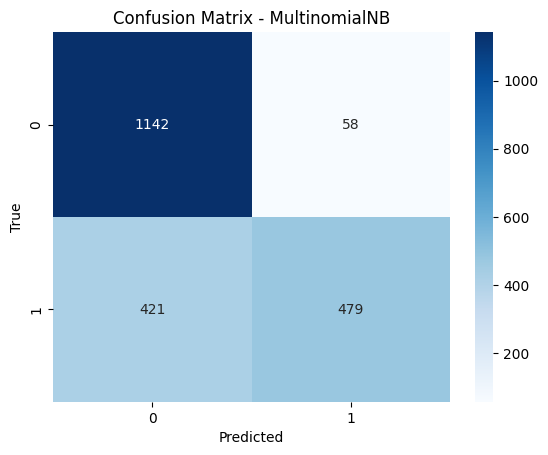


=== ComplementNB ===
Accuracy: 0.8386
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1200
           1       0.85      0.75      0.80       900

    accuracy                           0.84      2100
   macro avg       0.84      0.83      0.83      2100
weighted avg       0.84      0.84      0.84      2100



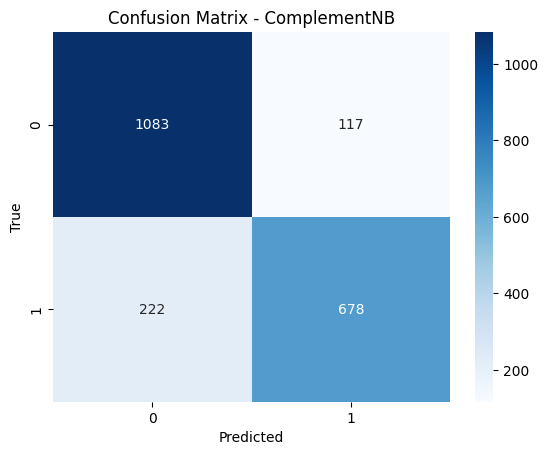


=== BernoulliNB ===
Accuracy: 0.7633
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1200
           1       0.75      0.68      0.71       900

    accuracy                           0.76      2100
   macro avg       0.76      0.75      0.76      2100
weighted avg       0.76      0.76      0.76      2100



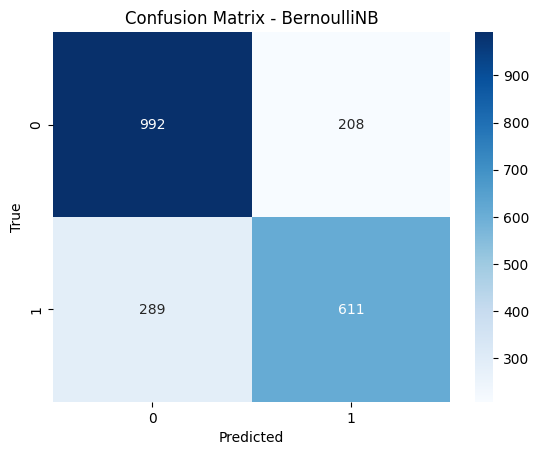


Сравнение моделей
           Model  Accuracy
0     GaussianNB  0.853333
2   ComplementNB  0.838571
1  MultinomialNB  0.771905
3    BernoulliNB  0.763333


In [16]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    results.append((name, acc))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
print("\nСравнение моделей")
print(results_df)

<b>Вывод: </b> Cреди рассмотренных реализаций наивного байесовского классификатора наилучшую точность показал GaussianNB (85.3%), что делает его предпочтительным выбором для данного набора данных; остальные варианты - ComplementNB (83.9%), MultinomialNB (77.2%) и BernoulliNB (76.3%)- уступают ему по качеству классификации.

### Деревья решений (Decision Tree)

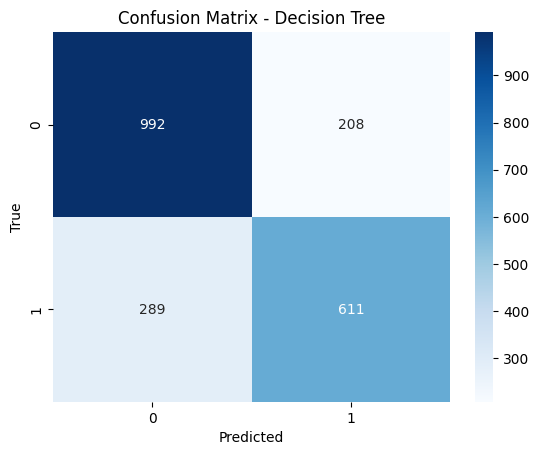

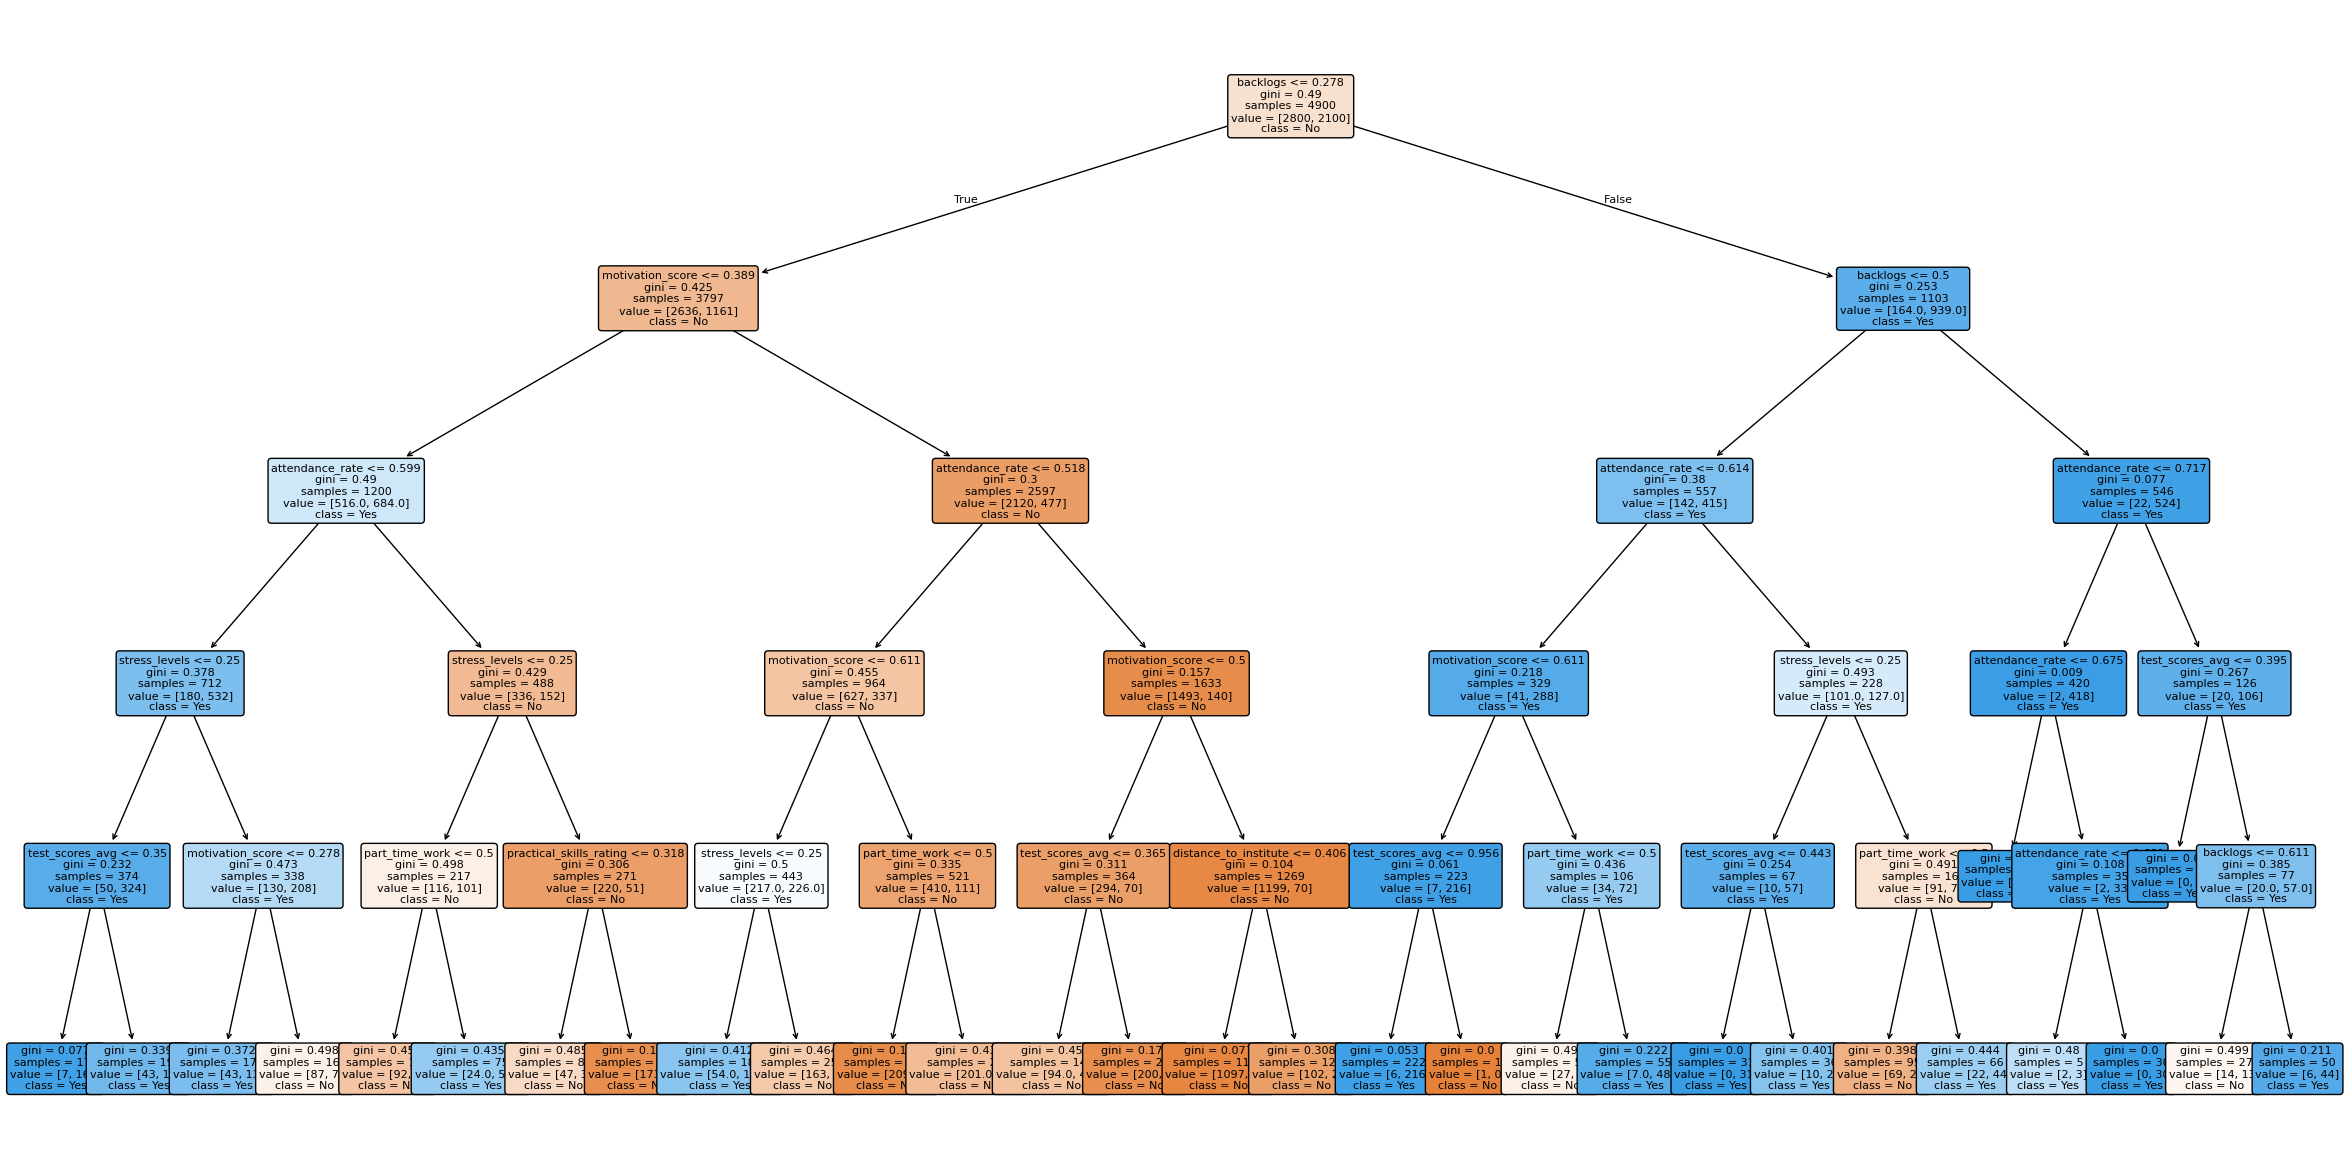

In [17]:
model = DecisionTreeClassifier(max_depth = 5,random_state=42)
model.fit(X_train, y_train)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


plt.figure(figsize=(30, 15))
plot_tree(
    model,
    filled=True,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    rounded=True,
    fontsize=8
)
plt.show()

### Линейный дискриминантный анализ (Linear Discriminant Analysis);

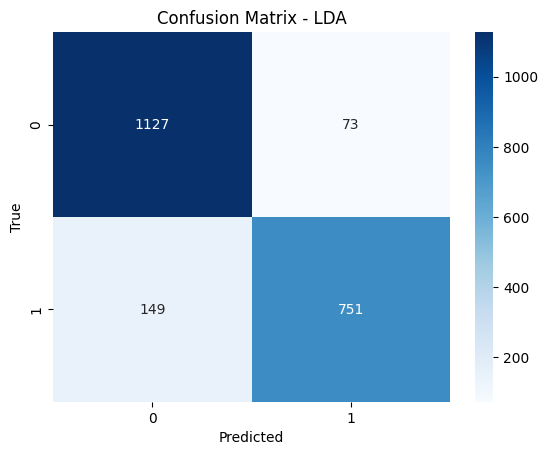

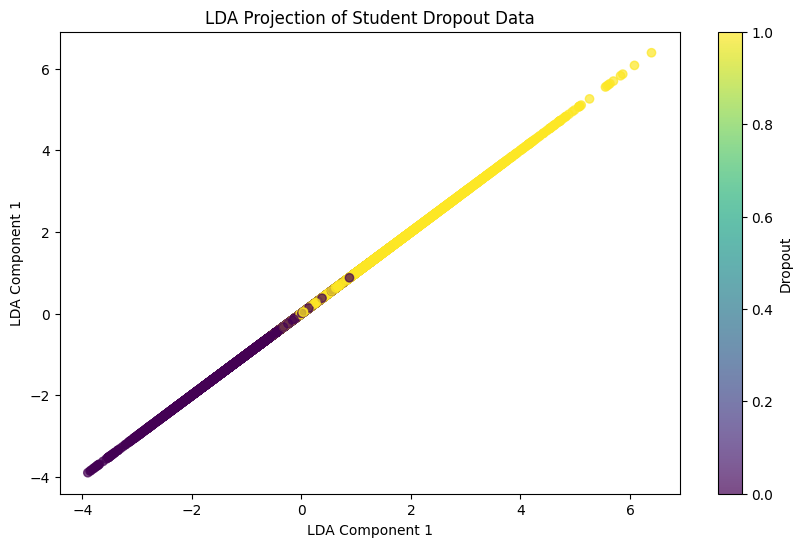

In [18]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LDA")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

X_lda = lda.transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_lda[:,0], X_lda[:,0], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 1')
plt.title('LDA Projection of Student Dropout Data')
plt.colorbar(label='Dropout')
plt.show()

**Вывод:** График проекции данных методом LDA показывает, что классы (отчисление/не отчисление) хорошо разделяются по первой компоненте - точки с высокой вероятностью отчисления (ярко-жёлтые) сконцентрированы в правой части графика, а с низкой - в левой. Это говорит о том, что LDA успешно выделил направление, максимально разделяющее классы, и подтверждает его эффективность для данной задачи классификации.

### Метод опорных векторов (Support Vector Machines);

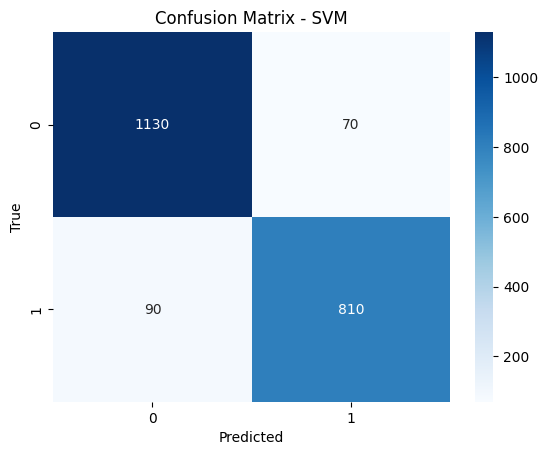

In [19]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Метод ближайших соседей (k-Nearest Neighbors)

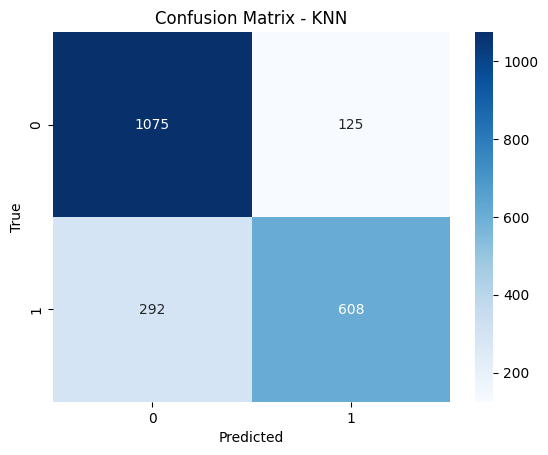

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Cравнение качества работы классификаторов

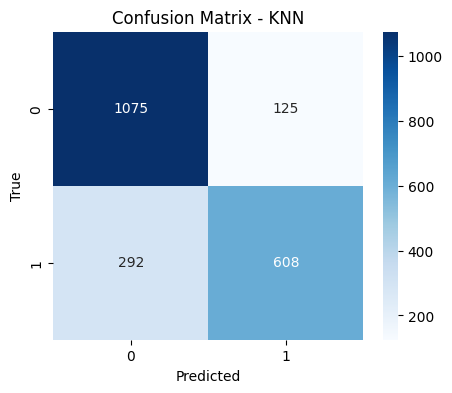

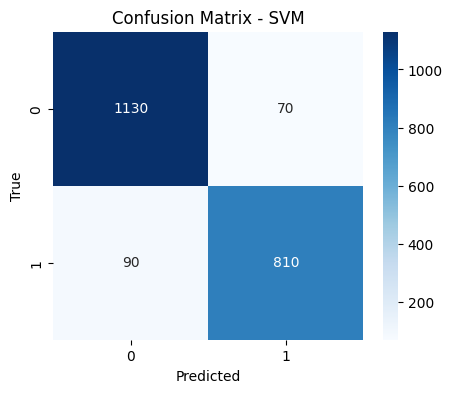

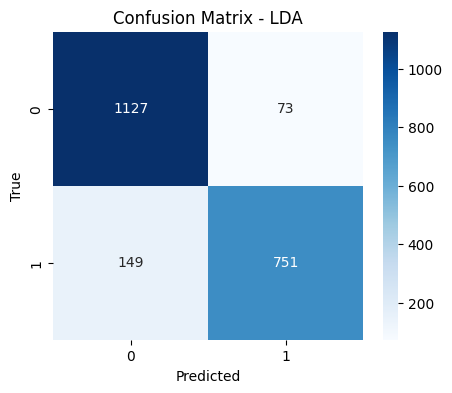

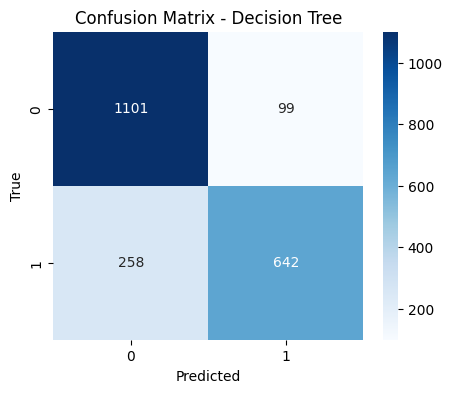

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
1,SVM,0.923810,0.920455,0.900000,0.910112,0.980185
2,LDA,0.894286,0.911408,0.834444,0.871230,0.963004
3,Decision Tree,0.830000,0.866397,0.713333,0.782450,0.890375
0,KNN,0.801429,0.829468,0.675556,0.744642,0.869971


In [21]:
trained_models = {
    "KNN": knn,
    "SVM": svm_model,
    "LDA": lda,
    "Decision Tree": model
}

results = []

for name, mdl in trained_models.items():
    
    y_pred = mdl.predict(X_test)
    
    if hasattr(mdl, "predict_proba"):
        y_proba = mdl.predict_proba(X_test)[:,1]
    else:
        y_proba = mdl.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC-ROC": auc
    })
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
results_df

<b>Вывод: </b>Наиболее эффективной моделью оказался SVM — он показал наивысшую точность (92.4%), отличный баланс между прецизионностью и полнотой (F1=0.91), а также рекордную AUC-ROC 0.98, что подтверждает его способность точно отделять классы; матрица ошибок демонстрирует минимальное количество ложных срабатываний (70) и пропущенных случаев (90). LDA занял второе место — хорошая точность (89.4%) и высокая AUC (0.96), но заметно ниже полнота (83.4%), что означает больше пропущенных положительных случаев (149). KNN и Decision Tree уступают по всем метрикам: KNN имеет самую низкую точность (80.1%) и очень низкую полноту (67.6%), что видно по большому числу пропущенных случаев (292), а Decision Tree, хотя и лучше KNN, всё же показывает слабую полноту (71.3%) и AUC (0.89). Таким образом, для задачи с акцентом на точность и надёжное обнаружение обоих классов оптимальным выбором является SVM.

In [22]:
param_grids = {
    "LDA": {
        "solver": ["svd", "lsqr", "eigen"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    "Decision Tree": {
        "max_depth": [3, 5, 7, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }
}

tuning_results = []

for name, model in [("LDA", LinearDiscriminantAnalysis()),
                    ("SVM", SVC(probability=True, random_state=42)),
                    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
                    ("KNN", KNeighborsClassifier())]:

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="accuracy",
        cv=5,
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:,1]
    else:
        y_proba = best_model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

        acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    tuning_results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC-ROC": auc
    })

tuning_df = pd.DataFrame(tuning_results).sort_values(by="Accuracy", ascending=False)
tuning_df

,Model,Best Params,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,LDA,{'solver': 'svd'},0.83,0.911408,0.834444,0.871230,0.963004
1,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.83,0.910100,0.911111,0.910605,0.981493
2,Decision Tree,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.83,0.822978,0.780000,0.800913,0.894871
3,KNN,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.83,0.894970,0.672222,0.767766,0.915189


<b>Вывод:</b> Все модели показали одинаковую точность 0.83, однако их детальные метрики различаются: SVM демонстрирует наилучший баланс между полнотой, прецизионностью и F1-мерой (0.91), а также достигает самой высокой AUC-ROC - 0.981, что говорит о превосходной способности отделять классы; LDA близок к SVM по качеству, особенно по AUC-ROC (0.963) и F1-мере, при этом Decision Tree и KNN уступают - у дерева ниже F1 и AUC, а у KNN особенно низкая полнота (0.67), несмотря на хорошую прецизионность. Таким образом, лучшей моделью по совокупности метрик является SVM с RBF-ядром, так как она обеспечивает наиболее стабильные и сбалансированные результаты.

f:\ml\LAB3\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7497 - loss: 0.5119 - val_accuracy: 0.8122 - val_loss: 0.3798
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8605 - loss: 0.3147 - val_accuracy: 0.8765 - val_loss: 0.2828
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8781 - loss: 0.2648 - val_accuracy: 0.8643 - val_loss: 0.2889
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8857 - loss: 0.2546 - val_accuracy: 0.8796 - val_loss: 0.2626
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8903 - loss: 0.2433 - val_accuracy: 0.8786 - val_loss: 0.2583
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8921 - loss: 0.2406 - val_accuracy: 0.8837 - val_loss: 0.2555
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8962 - loss: 0.2319 - val_accuracy: 0.8898 - val_loss: 0.2550
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8964 - loss: 0.2246 - val_accuracy: 0

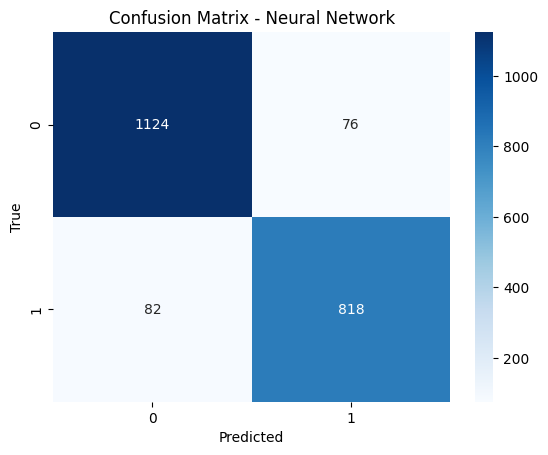

In [24]:
tensorboard_cb = callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

def build_model(input_shape, layers_units=[32,16], learning_rate=0.001):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(input_shape,)))
    
    for units in layers_units:
        model.add(layers.Dense(units, activation="relu"))
    
    model.add(layers.Dense(1, activation="sigmoid"))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

layers_units = [64, 32]
learning_rate = 0.001
batch_size = 32
epochs = 50

model = build_model(input_shape=X_train.shape[1], layers_units=layers_units, learning_rate=learning_rate)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[tensorboard_cb],
    verbose=1
)

y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


plt.show()

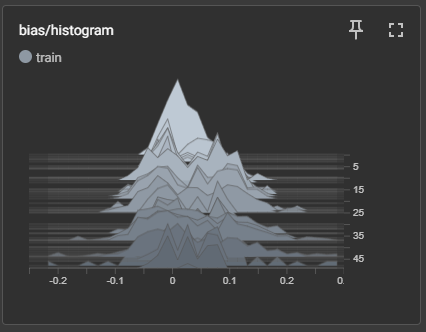

На графике видно, что смещение в основном сосредоточено вокруг нулевой отметки, что указывает на отсутствие систематической ошибки в предсказаниях модели, однако присутствуют небольшие выбросы как в положительную, так и в отрицательную сторону, особенно на ранних этапах обучения; со временем распределение становится более узким и стабильным, что свидетельствует о постепенной стабилизации модели и снижении вариативности ошибок.

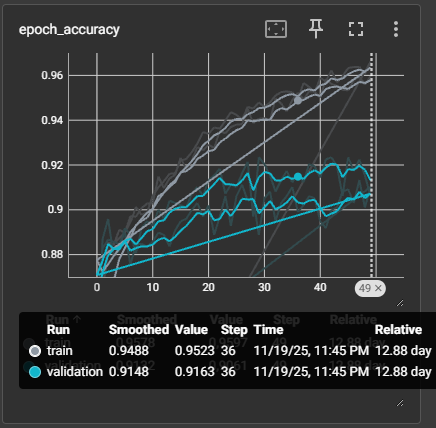

График epoch_accuracy показывает, что модель демонстрирует устойчивый рост точности как на обучающей (train), так и на валидационной (validation) выборках в течение 49 эпох, при этом конечная точность на обучающей выборке составляет 0.9578 (сглаженное значение 0.9597), а на валидационной - 0.9132 (сглаженное значение 0.9061), что указывает на хорошее обучение без явных признаков переобучения, поскольку разрыв между train и validation остается относительно небольшим и стабильным.

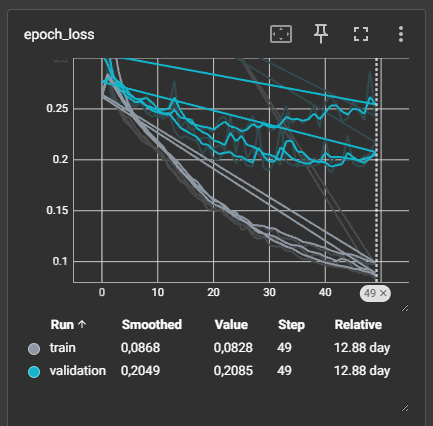

Анализ графика epoch_loss показывает, что как обучающая (train), так и валидационная (validation) функции потерь стабильно снижаются в течение 49 эпох, достигая значений 0.0868 (сглаженное) и 0.2049 (сглаженное) соответственно, что свидетельствует о качественном обучении модели; при этом небольшой разрыв между train и validation loss указывает на отсутствие выраженного переобучения.

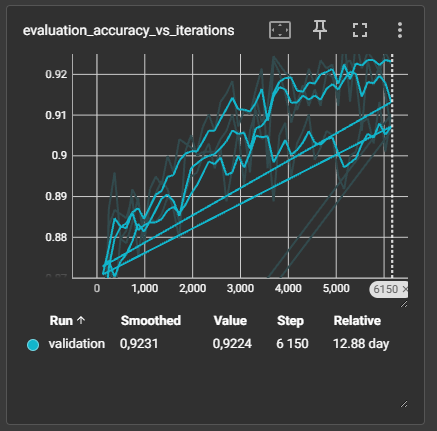

Модель показала стабильное и надежное обучение - точность на валидации постепенно росла до 92%, а потери падали без резких скачков, что говорит о том, что она хорошо учится, а не просто запоминает данные. Разница между обучением и проверкой небольшая, значит, модель обобщает правильно. Скорость обучения оставалась неизменной на уровне 0.001.

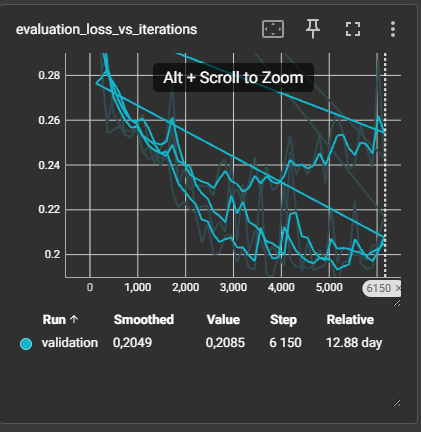

Модель уверенно сходится: потери на валидации стабильно снижаются по мере обучения, достигая значения 0.2049 к 6150-й итерации, что говорит о качественном обучении без переобучения, так как нет резких скачков или роста ошибки в конце. Несколько кривых на графике показывают, что результаты воспроизводимы по разным запускам, а сглаженная линия подтверждает общую тенденцию улучшения.

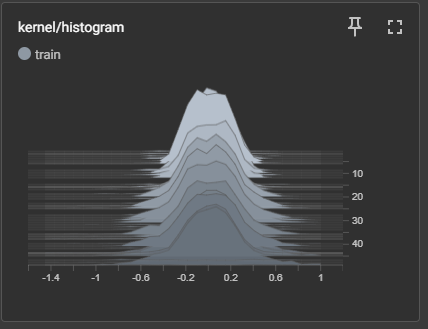

Видно, что распределения остаются устойчивыми и симметричными относительно нуля, что говорит о стабильном обучении и отсутствии проблем вроде исчезающих или взрывающихся градиентов.